In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

2.5.0


In [9]:
# Download Auto MPG Dataset using pandas
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [10]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [11]:
# print out the number of unknown values for each category in the dataset
dataset.isna().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [12]:
# drop those rows with unknown values
dataset = dataset.dropna()

In [13]:
# convert the "Origin" column from numeric to categorical with one-hot encoding
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [14]:
# convert with pd.get_dummies
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [15]:
#split data into train and test set
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

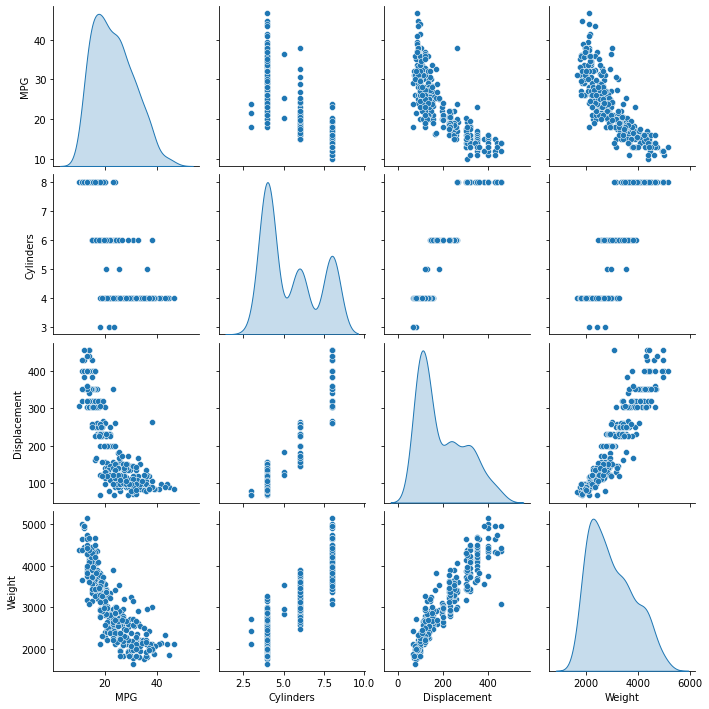

In [16]:
#visualize data
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [17]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [19]:
#split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [20]:
train_dataset.describe().transpose()[['mean','std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [21]:
# create Normalization layer
normalizer = preprocessing.Normalization(axis = -1)


In [22]:
normalizer.adapt(np.array(train_features))

In [23]:
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [62]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [64]:
# Linear Regression to predict MPG from Horsepower (y=mx+b)

# Create horsepower Normalization layer
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [65]:
# use layers.Dense to produce 1 output after applying linear transformation
horsepower_model = tf.keras.Sequential([horsepower_normalizer, layers.Dense(units=1)])
horsepower_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [66]:
#predict on first 10 horse-power values
horsepower_model.predict(horsepower[:10])


array([[ 0.04 ],
       [ 0.023],
       [-0.074],
       [ 0.056],
       [ 0.051],
       [ 0.02 ],
       [ 0.06 ],
       [ 0.051],
       [ 0.013],
       [ 0.023]], dtype=float32)

In [67]:
#configure model training procedure using Model.compile()
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [68]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    #verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 0s 22ms/step - loss: 22.8753 - val_loss: 22.9343
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 22.0717 - val_loss: 22.1347
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 21.2623 - val_loss: 21.3346
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 20.4628 - val_loss: 20.5345
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 19.6622 - val_loss: 19.7346
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 18.8622 - val_loss: 18.9345
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 18.0629 - val_loss: 18.1345
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 17.2615 - val_loss: 17.3346
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 16.4622 - val_loss: 16.5348
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 15.6620 - val_loss: 15.7348
Epoch 11

In [69]:
# visualize the model's training progress using stats in history object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804187,4.179572,95
96,3.803041,4.192927,96
97,3.802884,4.190622,97
98,3.811203,4.202964,98
99,3.802369,4.178842,99


In [70]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

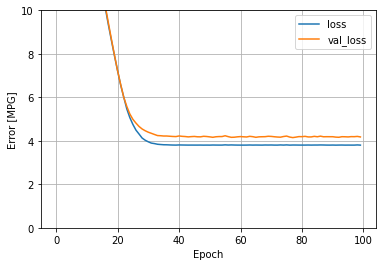

In [71]:
plot_loss(history)

In [73]:
test_results = {}
test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0
)

In [74]:
# look at model's predictions as a function of input
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [75]:
def plot_horsepower(x,y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label = 'Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

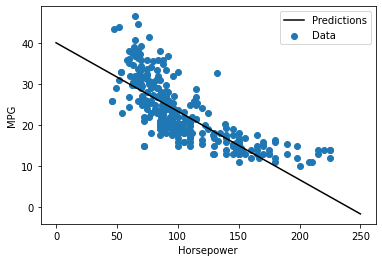

In [76]:
plot_horsepower(x,y)

In [77]:
# Multiple inputs (y=mx+b) with "m" this time as a matrix and "b" as a vector

# Use Normalization layer that was adapted to the whole dataset
linear_model = tf.keras.Sequential([normalizer, layers.Dense(units=1)])

In [78]:
linear_model.predict(train_features[:10])

array([[ 1.194],
       [ 0.161],
       [-2.473],
       [ 0.869],
       [ 1.732],
       [-1.056],
       [ 1.851],
       [ 0.334],
       [-0.617],
       [ 1.866]], dtype=float32)

In [80]:
# we can now see the input shape of the kernel has been altered
linear_model.layers[1].kernel

<tf.Variable 'dense_4/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.32 ],
       [-0.683],
       [ 0.314],
       [-0.713],
       [-0.089],
       [-0.056],
       [ 0.623],
       [ 0.656],
       [ 0.377]], dtype=float32)>

In [82]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [83]:
%%time
history = linear_model.fit(
    train_features, train_labels,
    epochs = 100,
    #Calculate validation results on 20% of the training data
    validation_split = 0.2
)

Epoch 1/100
8/8 [==============================] - 0s 23ms/step - loss: 22.9042 - val_loss: 23.0462
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 22.0511 - val_loss: 22.3190
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 21.2227 - val_loss: 21.5591
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 20.4054 - val_loss: 20.8282
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 19.6033 - val_loss: 20.1000
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 18.8044 - val_loss: 19.4055
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 17.9455 - val_loss: 18.6814
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 17.1324 - val_loss: 17.9392
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 16.3318 - val_loss: 17.2269
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 15.4919 - val_loss: 16.5082
Epoch 11

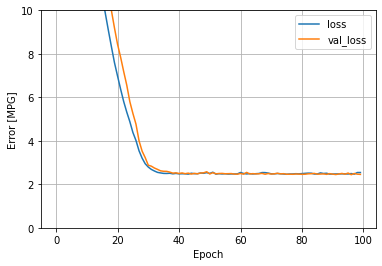

In [84]:
plot_loss(history)

In [85]:
# collect results on the test set for later
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)

In [95]:
# DNN that contains:
# Normalization layer
# 2 hidden, nonlinear, Dense layers using relu nonlinearity
# A linear single-output layer

def build_and_compile_model(norm):
  model = keras.Sequential([
                            norm,
                            layers.Dense(64, activation='relu'),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
  ])
  model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [96]:
# start with single Horsepower input
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [97]:
dnn_horsepower_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [98]:
# Train the model
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2, epochs=100
)

Epoch 1/100
8/8 [==============================] - 1s 23ms/step - loss: 23.0861 - val_loss: 23.4559
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 22.8467 - val_loss: 23.2020
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 22.5932 - val_loss: 22.9059
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 22.2834 - val_loss: 22.5397
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 21.8959 - val_loss: 22.0876
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 21.4231 - val_loss: 21.5037
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 20.8050 - val_loss: 20.7594
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 20.0075 - val_loss: 19.8112
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 19.0060 - val_loss: 18.6668
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 17.8411 - val_loss: 17.3448
Epoch 11

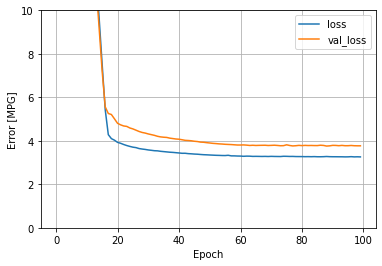

In [99]:
plot_loss(history)

In [100]:
# plot predictions as a function of Horsepower
# we will be able to see how this model 
# takes advantage of the nonlinearity provided by the hidden layers
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

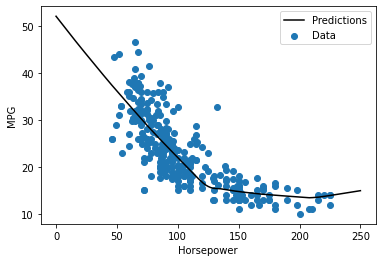

In [101]:
plot_horsepower(x, y)

In [102]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [103]:
# Full Model
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_11 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [104]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.45 s, sys: 156 ms, total: 3.61 s
Wall time: 5.52 s


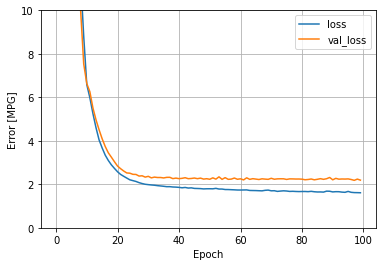

In [105]:
plot_loss(history)

In [106]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)


In [107]:
# compare the performance of all 4 models
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.642222
linear_model,2.444023
dnn_horsepower_model,2.925996
dnn_model,1.716390


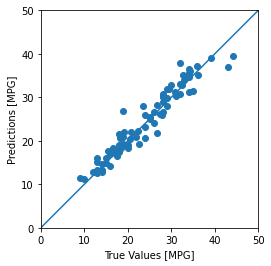

In [108]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

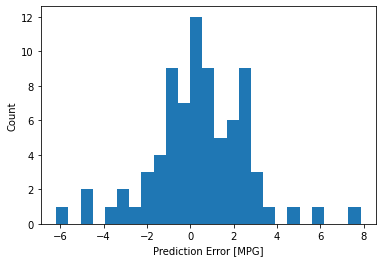

In [109]:
# look at error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [110]:
# save model for later use
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [111]:
# if we reload the saved model we get an identical output
reloaded = tf.keras.models.load_model('dnn_model')
test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels
)

3/3 [==============================] - 0s 4ms/step - loss: 1.7164


In [112]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.642222
linear_model,2.444023
dnn_horsepower_model,2.925996
dnn_model,1.716390
reloaded,1.716390
